# 基于CIFAR10仿真ResNet

In [1]:
from __future__ import print_function

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
train_set = torchvision.datasets.CIFAR10('../data', train=True, 
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('../data', train=False, 
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, 
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, 
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


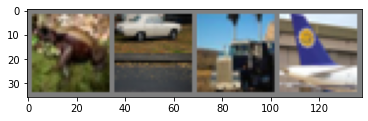

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### BasicBlock

![image.png](../imgs/fig2.png)
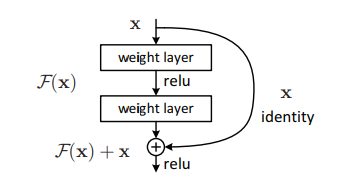

In [6]:
class BasicBlock(nn.Module):
    """
    对于浅层网络，我们使用基本的Block
    基础块没有维度压缩，所以expansion=1
    """
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        # 如果输入输出维度不等，则使用1x1卷积层来改变维度
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
            
    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [7]:
# 测试
basic_block = BasicBlock(64, 128)
print(basic_block)
x = torch.randn(2, 64, 32, 32)
y = basic_block(x)
print(y.shape)

BasicBlock(
  (features): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 128, 32, 32])


### Bottleneck Block
![image.png](../imgs/fig5.png)
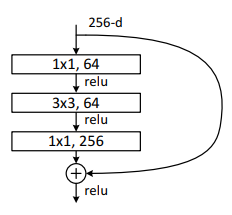

In [8]:
class Bottleneck(nn.Module):
    """
    对于深层网络，我们使用BottleNeck，论文中提出其拥有近似的计算复杂度，但能节省很多资源
    zip_channels: 压缩后的维数，最后输出的维数是 expansion * zip_channels
    """
    expansion = 4
    
    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [9]:
# 测试
bottleneck = Bottleneck(256, 128)
print(bottleneck)
x = torch.randn(2, 256, 32, 32)
y = bottleneck(x)
print(y.shape)

Bottleneck(
  (features): Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 512, 32, 32])


### ResNet
![image.png](../imgs/fig3.png)
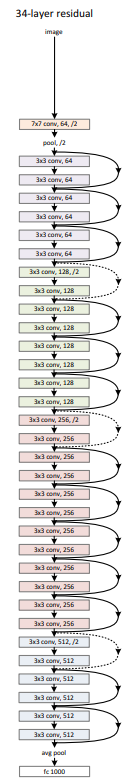

In [10]:
class ResNet(nn.Module):
    """
    不同的ResNet架构都是统一的一层特征提取、四层残差，不同点在于每层残差的深度。
    对于cifar10，feature map size的变化如下：
    (32, 32, 3) -> [Conv2d] -> (32, 32, 64) -> [Res1] -> (32, 32, 64) -> [Res2] 
 -> (16, 16, 128) -> [Res3] -> (8, 8, 256) ->[Res4] -> (4, 4, 512) -> [AvgPool] 
 -> (1, 1, 512) -> [Reshape] -> (512) -> [Linear] -> (10)
    """
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # cifar10经过上述结构后，到这里的feature map size是 4 x 4 x 512 x expansion
        # 所以这里用了 4 x 4 的平均池化
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 第一个block要进行降采样
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            # 如果是Bottleneck Block的话需要对每层输入的维度进行压缩，压缩后再增加维数
            # 所以每层的输入维数也要跟着变
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [11]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

In [12]:
net = ResNet34().to(device)
print(net)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [13]:
# 测试
x = torch.randn(2, 3, 32, 32).to(device)
y = net(x)
print(y.shape)

torch.Size([2, 10])


In [14]:
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.1, patience=3, verbose=True)

In [18]:
# Training
def train(epoch):
    print('\nEpoch: %d' % (epoch))
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.6f |  Acc: %.3f%% (%d/%d)' %
                  (epoch + 1, batch_idx + 1, train_loss, 100.*correct/total, correct, total))
    return train_loss

In [21]:
load_model = False
if load_model:
    checkpoint = torch.load('./checkpoint/res18.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 0


In [23]:
for epoch in range(start_epoch, 50):
    loss = train(epoch)
    print('Total loss: %.6f' % loss)
    start_epoch = epoch
    scheduler.step(loss)


Epoch: 0
[1,   100] loss: 118.672118 |  Acc: 56.953% (7290/12800)
[1,   200] loss: 235.403772 |  Acc: 57.355% (14683/25600)
[1,   300] loss: 342.972803 |  Acc: 58.721% (22549/38400)
Total loss: 436.702453

Epoch: 1
[2,   100] loss: 95.490529 |  Acc: 65.930% (8439/12800)
[2,   200] loss: 189.245391 |  Acc: 66.246% (16959/25600)
[2,   300] loss: 279.333860 |  Acc: 66.758% (25635/38400)
Total loss: 357.071455

Epoch: 2
[3,   100] loss: 76.589579 |  Acc: 73.203% (9370/12800)
[3,   200] loss: 151.513288 |  Acc: 73.492% (18814/25600)
[3,   300] loss: 224.068864 |  Acc: 73.836% (28353/38400)
Total loss: 286.139592

Epoch: 3
[4,   100] loss: 62.455524 |  Acc: 78.664% (10069/12800)
[4,   200] loss: 125.946750 |  Acc: 78.246% (20031/25600)
[4,   300] loss: 186.423765 |  Acc: 78.414% (30111/38400)
Total loss: 240.281207

Epoch: 4
[5,   100] loss: 54.547970 |  Acc: 81.414% (10421/12800)
[5,   200] loss: 110.654127 |  Acc: 80.898% (20710/25600)
[5,   300] loss: 166.249208 |  Acc: 80.919% (31073/38

In [24]:
save_model = True
if save_model:
    state = {
        'net': net.state_dict(),
        'epoch': epoch,
    }
    os.makedirs('checkpoint', exist_ok=True)
    torch.save(state, './checkpoint/res18.ckpt')

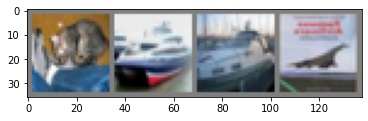

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship   car plane
Accuracy of the network on the 10000 test images: 90 %
Accuracy of plane : 90 %
Accuracy of   car : 100 %
Accuracy of  bird : 81 %
Accuracy of   cat : 72 %
Accuracy of  deer : 89 %
Accuracy of   dog : 87 %
Accuracy of  frog : 94 %
Accuracy of horse : 93 %
Accuracy of  ship : 95 %
Accuracy of truck : 96 %


In [25]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))